# Image classification with a CNN Model on the Cats vs Dogs dataset using Tensorflow Keras

**Author:** [Ashaduzzaman Piash](www.linkedin.com/in/ashaduzzaman-sarker-piash)<br>
**Date created:** 2024/06/16<br>

## Introduction

This example demonstrates how to perform image classification from the ground up, beginning with JPEG image files stored on disk, without using pre-trained weights or pre-built Keras Application models. The process is illustrated using the Kaggle Cats vs Dogs binary classification dataset.

We utilize the `image_dataset_from_directory` function to create the datasets, and employ Keras image preprocessing layers for image standardization and data augmentation.

---

## Setup

In [2]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

In [3]:
# Raw data download
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   110M      0  0:00:07  0:00:07 --:--:--  122M


In [4]:
# Unzip the downloaded dataset
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [5]:
 # Explore PetImages folder
 !ls PetImages

Cat  Dog


In [6]:
# Filter out corrupted images that do not feature the string "JFIF" in their header
# JFIF(JPEG File Interchange Format)

num_skipped = 0
for folder_name in ('Cat', 'Dog'):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, 'rb')
            is_jfif = b'JFIF' in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f'Deleted {num_skipped} images.')

Deleted 1590 images.


## Generate a Dataset

In [7]:
image_size = (224, 224)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='both',
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

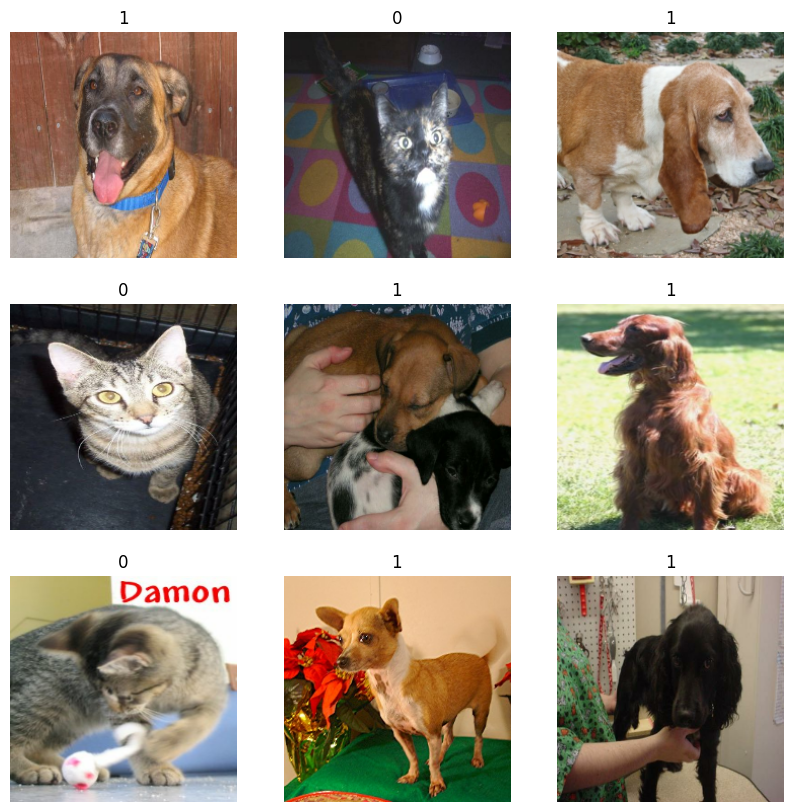

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

## Data Augmentation

In [9]:
# Using image data augmentation
data_augmentation_layers = [
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

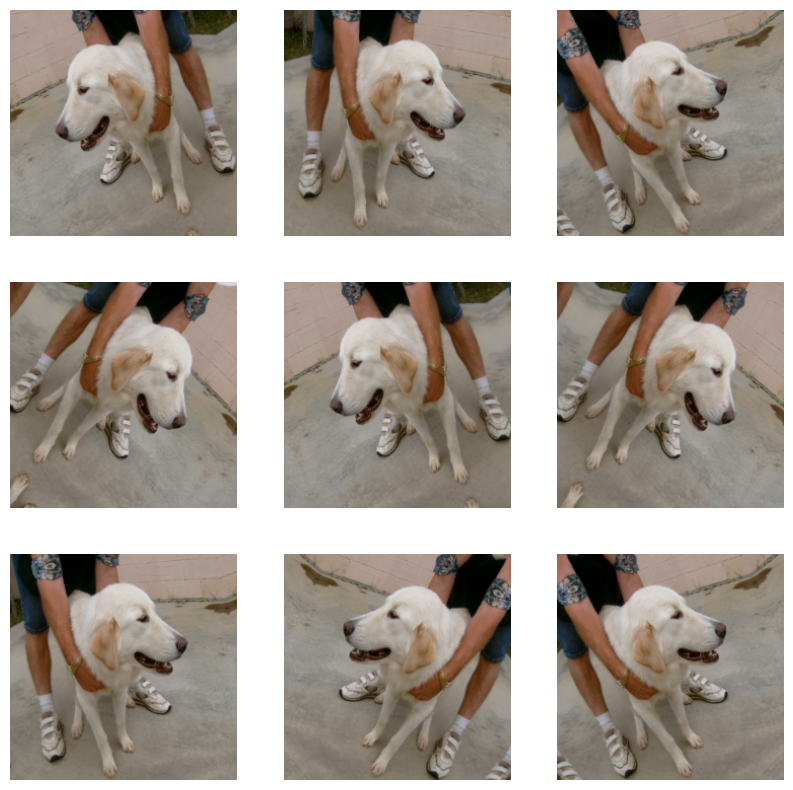

In [10]:
# Visualize the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(augmented_images[0]).astype('uint8'))
    plt.axis('off')

## Standardizing the data

Our image are already in a standard size (224x224), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

## Preprocess the dataset for model

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a CNN model

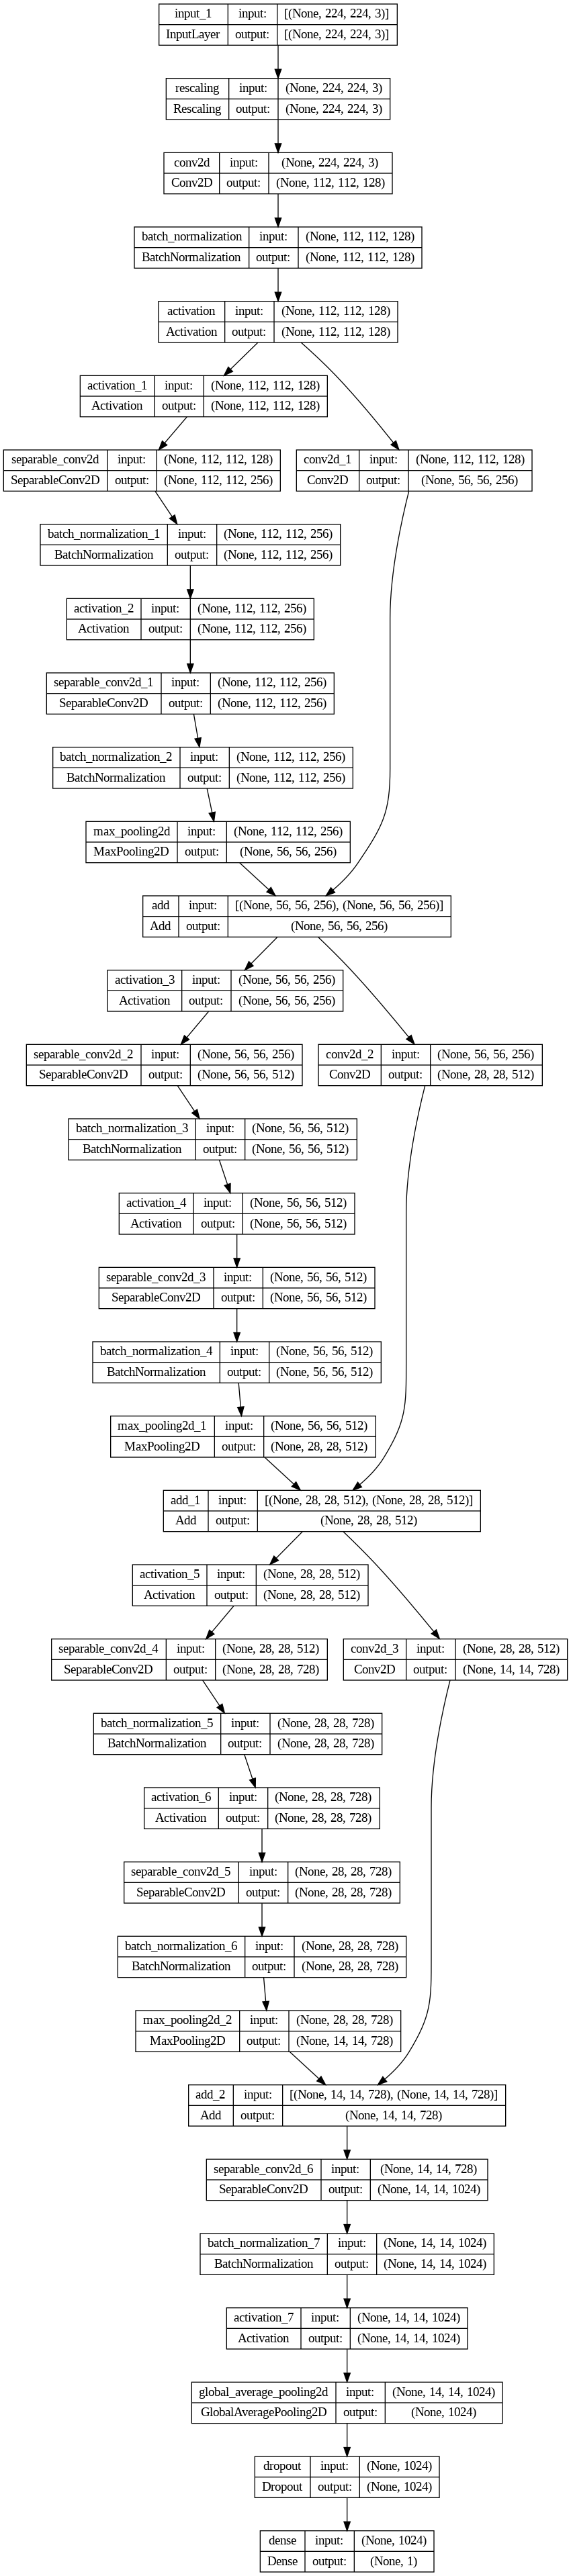

In [12]:
# We'll build a small version of the Xception network
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry Block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x # Set aside residual

  for size in [256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    units =1
  else:
    units = num_classes

  x = layers.Dropout(0.25)(x)
  # We specify activation=None so as to return logits
  outputs = layers.Dense(units, activation=None)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 5 #25

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='auc')],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
  9/586 [..............................] - ETA: 4:52:47 - loss: 0.6941 - auc: 0.5729

## Run inference on new data

In [ ]:
img = keras.utils.load_image('PetImages/Dog/10739.jpg', target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0) # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f'This image is {100 * (1-score):.2f}% cat and {100* score:.2f}% dog.')